## Genome variation

My work involves the analysis of genetic variation from next-generation sequencing experiments. After running the sequence data through some variant calling pipeline like [GATK](https://www.broadinstitute.org/gatk/) I end up with a data set containing genotype calls for millions variants (SNPs, INDELS, etc.) on hundreds (soon to be thousands) of individuals. I study the malaria-carrying mosquito *Anopheles gambiae* but the principles are similar no matter what organism you're working on.

Once these data are in hand, there are many analyses that can be performed. These typically begin with quality-control (looking for poor-quality features in the data), but from there the possibilities are endless. Because DNA mutates and recombines as it passes from one generation to the next, every genome captures information about its own history. When you have data on many genomes from different populations, it's pretty amazing what you can begin to infer, from recent selection on insecticide resistance mutations to ancient population expansions and crashes.

## Exploratory analysis

Dealing with a data set of this richness, complexity and scale, you have to explore the data. When you're doing exploratory analyses, you don't start out with a concrete analysis plan, rather the plan emerges and evolves as you discover different features of the data. It's a very fluid process, and there are several things that can get in the way. 

First, things need to run fast. Typically this means seconds, minutes at a push. That means you can come up with an idea, run it, visualise the result, realise you did something stupid, re-run it a different way, visualise again, etc. If you're always having to go off for a cup of tea while something runs, it breaks the flow and you don't get very far.

Second, you want to avoid context-switching. That means you want to stay within the same computing environment, working with the same programming language, as much as possible. If you are always having to switch from one tool to another, writing out and parsing different text files, life becomes painful. You spend your time debugging weird errors and waiting for I/O.

## Scientific Python

I used to be a software engineer, and I did a lot of work in Python. When I started doing data analysis, naturally I stuck with what I knew. I was very happy to discover the rich ecosystem of general-purpose scientific software libraries available for Python.

At the heart of scientific computing in Python is [NumPy](http://www.numpy.org). NumPy is a library providing array-based numerical computing. Basically, this means you can do fast numerical computing whilst writing concise, readable code. 

As I started to work with large-scale genome variation data, I also started building some tools to work with data, based on NumPy. Partly this was out of necessity, partly frustration, partly as a learning exercise (you never really understand something until you've tried to code it yourself). Recently I decided to follow the example of many others developing NumPy-based programming libraries for specific scientific domains and package my tools up as a [scikit](https://scikits.appspot.com/scikits).

## scikit-allel

[`scikit-allel`](http://scikit-allel.readthedocs.org/en/latest/) is a Python library for exploratory analysis of large-scale genome variation data. It's still in an early stage of development, but there are some useful features, and I hope it will make life easier for others doing similar work to me.

Here's a quick illustration of a couple of features.

In [2]:
import numpy as np
import allel; print('scikit-allel', allel.__version__)
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

scikit-allel 0.20.1


I'm going to use data from the [Ag1000G phase 1 AR3 release](http://www.malariagen.net/data/ag1000g-phase1-AR3). I have a copy of the data downloaded to a local drive.

The data are stored in [HDF5 files](https://www.hdfgroup.org/HDF5/). Let's take a look.

In [3]:
callset_fn = '/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.h5" (mode r)>

In [4]:
# pick a chromosome to work with
chrom = '2L'

In [5]:
# access variants
variants = callset[chrom]['variants']
variants

<HDF5 group "/2L/variants" (66 members)>

Every genetic variant (in this case they are all SNPs) has a position on the genome. Working with these positions is a very common operation.

In [6]:
pos = allel.SortedIndex(variants['POS'])
pos

SortedIndex((10377280,), dtype=int32)
[   44688    44691    44732 ..., 49356426 49356429 49356435]

Let's plot the density of these variants over the chromosome.

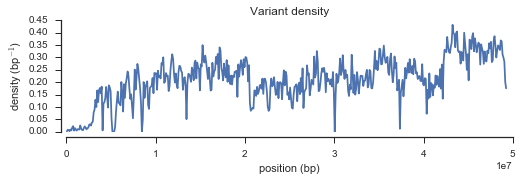

In [7]:
bin_width = 100000
bins = np.arange(0, pos.max(), bin_width)
# set X coordinate as bin midpoints
x = (bins[1:] + bins[:-1])/2
# compute variant density
h, _ = np.histogram(pos, bins=bins)
y = h / bin_width
# plot
fig, ax = plt.subplots(figsize=(8, 2))
sns.despine(ax=ax, offset=5)
ax.plot(x, y)
ax.set_xlabel('position (bp)')
ax.set_ylabel('density (bp$^{-1}$)')
ax.set_title('Variant density');

Let's say I have a gene of interest. I know what position it starts and ends, and I want to find variants within the gene.

In [8]:
start, stop = 2358158, 2431617
loc = pos.locate_range(start, stop)
loc

slice(25091, 26854, None)

I can use this slice to load genotype data for the region of interest.

In [9]:
g = allel.GenotypeArray(callset[chrom]['calldata']['genotype'][loc])
g

,0,1,2,3,4,...,760,761,762,763,764
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


There are various manipulations that can be done on a genotype array, e.g., convert to the number of alternate alleles per call.

In [10]:
gn = g.to_n_alt()
gn

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

From there we could compute genetic distance between each pair of individuals...

In [11]:
dist = allel.stats.pairwise_distance(gn, metric='euclidean')
dist

array([ 12.9614814 ,   1.41421356,   2.        , ...,   2.        ,
         2.        ,   0.        ])

...which we could quickly visualise...

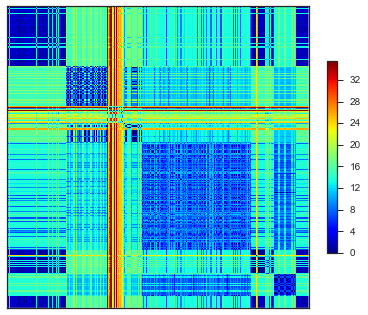

In [12]:
allel.plot.pairwise_distance(dist);

## Further reading

I will leave it there for now, but check out the [scikit-allel docs](http://scikit-allel.readthedocs.org/en/latest/index.html) for more information. There is a section on [data structures](http://scikit-allel.readthedocs.org/en/latest/model.html), which includes both contiguous in-memory and compressed data structures for dealing with very large arrays (made possible thanks to [bcolz](http://bcolz.blosc.org/)). There is also a [statistics](http://scikit-allel.readthedocs.org/en/latest/stats.html) section with various functions for computing diversity, Fst, LD, running PCA, and doing admixture tests, as well as a few useful plotting functions.

It is just a beginning, but hopefully a step in a good direction.

<hr/>

In [13]:
import os; print(os.environ['docker_image'])

cggh/biipy:v1.1.1
